# Introduction to Simple Linear Regression

AKA - Welcome to statistical modeling! Could also say - welcome to **Supervised Machine Learning**.

What do I mean by 'Supervised' ?

![Types of machine learning, broken down](images/machinelearning_supervisedunsupervised.png)

[Image Source](https://fr.mathworks.com/help/stats/machine-learning-in-matlab.html)

For our first model:

$$ y = m \cdot x + b $$

$$ \hat{Y} = \hat{\beta}_{j}X_{j} + \hat{\beta}_{0}$$

Here:

- $x$: input column (just one for now)
- $y$: output column (column we're trying to predict)

Solving for the coefficients $m$ and $b$ - our slope and y-intercept - based on the line that 'best' represents the relationship between $x$ and $y$, _assuming_ that relationship is a straight line.

As an example, let's say that we assume that spending money on TV advertising has an impact on our sales:

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Our data
df = pd.read_csv('data/Advertising.csv', index_col=0)[['TV', 'Sales']]

print(df.shape)
df.head()

(200, 2)


,TV,Sales
1,230.1,22.1
2,44.5,10.4
3,17.2,9.3
4,151.5,18.5
5,180.8,12.9


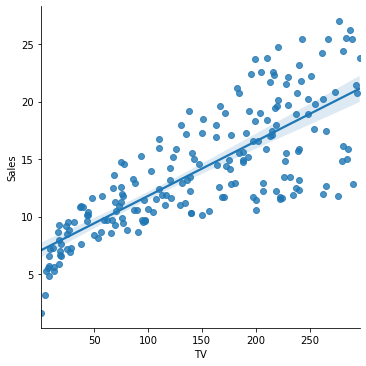

In [3]:
# seaborn even has a 'best fit line' plot
sns.lmplot(x='TV', y='Sales', data=df)
plt.show()  #assumption of linearity checked 

But what are those parameters found by seaborn above, and how can we solve for them?

## Linear Regression with `statsmodels`

`statsmodels` is more robust than `sklearn` for linear models, but as a library has a lot less functionality for modeling techniques.

[Check the documentation](http://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.OLS.html#statsmodels.regression.linear_model.OLS)

Now let's use statsmodel to fit a linear model to our data.

In [4]:
import statsmodels.api as sm

In [5]:
df.head()

,TV,Sales
1,230.1,22.1
2,44.5,10.4
3,17.2,9.3
4,151.5,18.5
5,180.8,12.9


We use capital `X` to capture inputs and lowercase `y` to capture the output:

In [7]:
X = df['TV'].values
print(X.shape)

y = df.Sales.values
print(y.shape)

(200,)
(200,)


In [7]:
# Now let's model!
model = sm.OLS(y, X, hasconst=False) # creating our model

In [8]:
results = model.fit() # actually fitting the model

In [9]:
results.params # seeing our coefficients - just one, we'll discuss in a sec

array([0.08324961])

In [10]:
results.predict([150, 2, 300]) # predicting for some random possible X values

array([12.48744131,  0.16649922, 24.97488262])

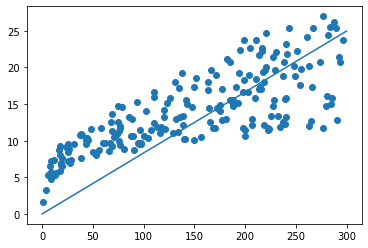

In [11]:
plt.scatter(df['TV'], df['Sales'])

x_pred_range = np.linspace(0, 300, 300)
plt.plot(x_pred_range, results.predict(x_pred_range))

plt.show()

Okay... just one parameter though, a slope - why no intercept? Because statsmodels is weird and assumes you add a constant manually if you want one.

In [12]:
X_with_const = sm.add_constant(X) # easiest way to add the constant
pd.DataFrame(X_with_const, columns=['ones', 'TV']).head() # showing the change

,ones,TV
0,1.0,230.1
1,1.0,44.5
2,1.0,17.2
3,1.0,151.5
4,1.0,180.8


In [13]:
model = sm.OLS(y, X_with_const, hasconst=True)
results = model.fit()
results.params

array([7.03259355, 0.04753664])

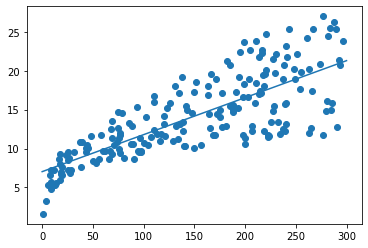

In [14]:
plt.scatter(df['TV'], df['Sales'])

x_pred_range = np.linspace(0, 300, 300)
plt.plot(x_pred_range, results.predict(sm.add_constant(x_pred_range)))

plt.show()

Neat.

So, uh... how'd we do?

In [15]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Tue, 08 Feb 2022   Prob (F-statistic):           1.47e-42
Time:                        10:12:40   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.0326      0.458     15.360      0.000       6.130       7.935
x1             0.0475      0.003     17.668      0.000       0.042       0.053
==============================================================================
Omnibus:                        0.531   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.767   Jarque-Bera (JB):                0.669
Skew:                          -0.089   Prob(JB):                        0.716
Kurtosis:                       2.779   Cond. No.                         338.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Understanding $R^{2}$ - How do we know what's 'best' ?

**The easiest way to think about an R2 score, also known as the Coefficient of Determination, is that it compares how much more variance in `y` you explain with your model compared to predicting that `y` is always the mean value.**

Let's explore:

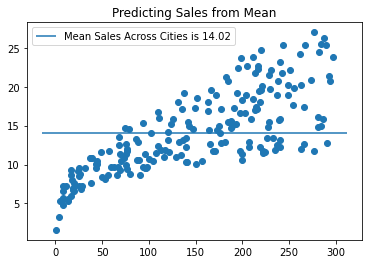

In [16]:
#Baseline model -- use the mean of y as a baseline 

plt.scatter(df['TV'], df['Sales'])
xmin, xmax = plt.xlim()

plt.hlines(y=df['Sales'].mean(),
           xmin=xmin, xmax=xmax,
           label=f'Mean Sales Across Cities is {df["Sales"].mean():.2f}')

plt.title('Predicting Sales from Mean')

plt.legend()
plt.show()

But as we can see this is not explaining what is going on in the data very well. We know this amount of errors as Total Sum of Squares.


$$ \text{Total Sum of Squares} = \sum\limits_{i=1}^{200} (y_{i} - \bar{y})^{2} $$

In [18]:
y_bar = y.mean()

TSS = sum((y - y_bar)**2)

print(TSS)

5417.148749999997


But after we fit a linear regression line we have a better fit than just "mean"

In [19]:
# Note that this bypasses needing to add the constant separately
y_pred = results.predict(sm.add_constant(X))

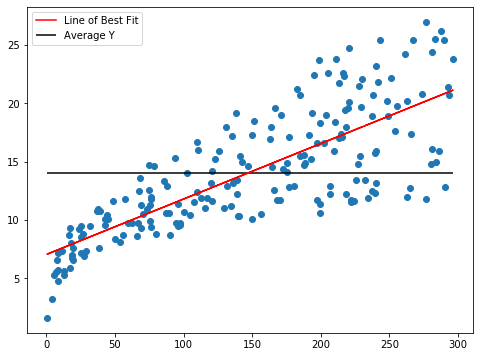

In [20]:
plt.figure(figsize=(8,6))
# this plots the actual data
plt.scatter(X, y)

# this plots the 'best' line
plt.plot(X, y_pred, label="Line of Best Fit", color='r')
# and this plots the 'average' line
plt.hlines(y_bar, X.min(), X.max(), label="Average Y")

plt.legend()
plt.show()

As we can see this line is also not 'perfect' from prediction point of view. Let's see how much is the total amount of error this time.

A **residual** is the difference between the actual value and the predicted value for a point we tried to predict where we knew the actual correct answer.

<img src="images/errors.png" cap="Transformed dataset"  width='500'/>

$$ \text{Squared Sum of Residuals} = \sum\limits_{i=1}^{n} (y_i - \text{y_pred}_{i})^{2}$$

In [21]:
residuals = y - y_pred

# now sum the squared residuals
RSS = sum(residuals**2)

RSS

2102.5305831313503

In [22]:
print(f'Total Squared Sum is {TSS:.3f}')
print(f'Residual Squared Sum is {RSS:.3f}')

Total Squared Sum is 5417.149
Residual Squared Sum is 2102.531


$R^{2}$ measurement is just their ratio:

 $$ R^{2} = \frac{TSS - RSS}{TSS} $$

In [23]:
R_squared = (TSS - RSS)/TSS

R_squared

0.611875050850071

In [24]:
# can grab this straight from our results
results.rsquared

0.611875050850071

In [25]:
# this is also given in the summary of results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           1.47e-42
Time:                        18:17:17   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.0326      0.458     15.360      0.000       6.130       7.935
x1             0.0475      0.003     17.668      0.000       0.042       0.053
==============================================================================
Omnibus:                        0.531   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.767   Jarque-Bera (JB):                0.669
Skew:                          -0.089   Prob(JB):                        0.716
Kurtosis:                       2.779   Cond. No.                         338.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Using `statsmodels`: $R^2$ and Making Predictions

In [26]:
# A Recap:
# we first construct our model
model = sm.OLS(y, sm.add_constant(X), hasconst=True)

# by fitting we learn 'best' coefficients for intercept and slope
fitted_model = model.fit()

# with summary method we can see all the relevant statistics
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           1.47e-42
Time:                        18:17:17   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.0326      0.458     15.360      0.000       6.130       7.935
x1             0.0475      0.003     17.668      0.000       0.042       0.053
==============================================================================
Omnibus:                        0.531   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.767   Jarque-Bera (JB):                0.669
Skew:                          -0.089   Prob(JB):                        0.716
Kurtosis:                       2.779   Cond. No.                         338.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
results.params

array([7.03259355, 0.04753664])

Suppose our company wants to invest $230K in TV ads in a city, how much sales would you expect on average for this city?

In [28]:
fitted_model.predict([1, 230])

array([17.96602085])

In [29]:
intercept = fitted_model.params[0]

slope = fitted_model.params[1]

Note that this prediction is nothing but 

$$ \text{Sales} = 0.0475 \times \text{TV Advertising} + 7.0326 $$

In [30]:
our_prediction = slope * 230 + intercept * 1
our_prediction

17.96602084872224

## Now with `sklearn`

In [4]:
from sklearn.linear_model import LinearRegression

In [5]:
# First, instantiate the model 
# note that we don't pass in our data yet - different from statsmodels
lr = LinearRegression()

In [8]:
# now, fit the model
lr.fit(df[['TV']], y)

# same as
# lr.fit(X.reshape(-1, 1), y) <- need .reshape because it's surprised X is one-dimensional

LinearRegression()

In [9]:
# best slope value slope
m = lr.coef_
print(m)

[0.04753664]


In [10]:
## best intercept value
b = lr.intercept_
print(b) #avg number of sales you would get if you had no predictors 

7.032593549127693


In [11]:
y_pred_manual = m*X + b
y_pred_model = lr.predict(X.reshape(-1, 1))

In [12]:
y_pred_manual == y_pred_model

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

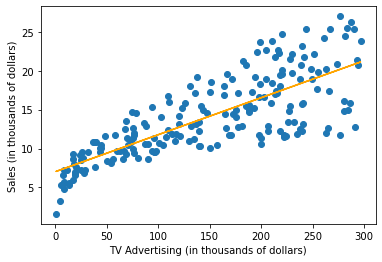

In [13]:
plt.scatter(X, y)
plt.plot(X, y_pred_model, color='orange')

plt.xlabel('TV Advertising (in thousands of dollars)')
plt.ylabel('Sales (in thousands of dollars)')

plt.show()

And the R2 score from sklearn?

In [15]:
from sklearn.metrics import r2_score

In [16]:
r2_score(y, y_pred_model) #that TV sales explains 62% if the variation in total sales 

0.611875050850071

## Beyond the $R^2$ Score

There are other metrics! 

#### Mean Absolute Error (MAE)

$$\text{MAE}(y, y_\text{pred}) = \frac{1}{n} \sum_{i=0}^{n} \left| y_i - y_\text{pred}i \right|$$

- Measures the average magnitude of errors regardless of direction, by calculating the total absolute value of errors and dividing by the number of samples (number of predictions made)
- This error term is in the same units as the target!

#### Mean Squared Error (MSE)

$$\text{MSE}(y, y_\text{pred}) = \frac{1}{n} \sum_{i=0}^{n} (y_i - y_\text{pred}i)^2$$

- Measures the average squared error, by calculating the sum of squared errors for all predictions then dividing by the number of samples (number of predictions)
- In other words - this is the Residual Sum of Squares (RSS) divided by the number of predictions!
- This error term is **NOT** in the same units as the target!

#### Root Mean Squared Error (RMSE)

$$\text{RMSE}(y, y_\text{pred}) = \sqrt{\frac{1}{n} \sum_{i=0}^{n} (y_i - y_\text{pred}i)^2}$$

- Measures the square root of the average squared error, by calculating the sum of squared errors for all predictions then dividing by the number of samples (number of predictions), then taking the square root of all that
- This error term is in the same units as the target!

Note - before, we were _maximizing_ R2 (best fit = largest R2 score). But we'd want to minimize these other error metrics.

Documentation: 
- [Regression Metrics in sklearn](https://scikit-learn.org/stable/modules/classes.html#regression-metrics)
- [User Guide for Regression Metrics in sklearn](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [42]:
print("Metrics:")
# R2
print(f"R2: {r2_score(y, y_pred_model):.3f}")
# MAE
print(f"Mean Absolute Error: {mean_absolute_error(y, y_pred_model):.3f}")
# MSE
print(f"Mean Squared Error: {mean_squared_error(y, y_pred_model):.3f}")
# RMSE - just MSE but set squared=False
print(f"Root Mean Squared Error: {mean_squared_error(y, y_pred_model, squared=False):.3f}")

Metrics:
R2: 0.612
Mean Absolute Error: 2.550
Mean Squared Error: 10.513
Root Mean Squared Error: 3.242


Note that I said that MAE and RMSE are both in the same units as our target, but you'll see that they are different here. What's the difference?

> "Taking the square root of the average squared errors has some interesting implications for RMSE. Since the errors are squared before they are averaged, the RMSE gives a relatively high weight to large errors. This means the RMSE should be more useful when large errors are particularly undesirable."

-- Source: ["MAE and RMSE — Which Metric is Better?"](https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d)

How can we interpret these?

- R2: "Our model accounts for 61.2% of the variance in our target"
- MAE/RMSE: "Our model's predictions are, on average, about __ thousands of dollars away from our actual target values"

An important note to keep in mind from now on:

!["all models are wrong but some are useful" quote picture](images/allmodelsarewrong.jpg)

[Image Source](https://twitter.com/cwodtke/status/1244433603666178049)